In [1]:
# Header for the notebook
from datetime import datetime
from IPython.display import display, Markdown

# Get the current date
title = "Template for a Jupyter Notebook"
current_date = datetime.now().strftime("%d %B %Y, %H:%M:%S")
authors = "Théo Lecomte , Baptiste Augros and Camille Jaffeux"

# Insert the date into the notebook
display(Markdown(f"# {title}"))
display(Markdown(f"{current_date}"))
display(Markdown(f"by {authors}"))

# Template for a Jupyter Notebook

14 November 2025, 15:22:05

by Théo Lecomte , Baptiste Augros and Camille Jaffeux

# MouseReCo

In [2]:
# imports (this is all you need for this assignment - please, do not import anything else)
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
# very useful for zoomable plots in Jupyter notebooks
%matplotlib widget

# import pandas as pd # we do not use pandas here

In [3]:
# if the present working directory is the directory of this file, change the path to the project root
if os.getcwd().endswith("notebooks"):
    os.chdir("..")

## Défnir les intervals

In [4]:
#load csv data
file_path = "001MoDe_R1.marker.csv"

# 🔹 Lecture du fichier brut (toutes les lignes)
with open(file_path, "r", encoding="utf-8") as f:
    lines = f.readlines()

# 🔹 On garde uniquement les lignes correspondant aux logs DoCycleChange
log_lines = [line.strip() for line in lines if "DoCycleChange" in line or "DoRecord" in line or "DoPause" in line]
# 🔹 Transformation en DataFrame (on split seulement les 3 premières valeurs)
df = pd.DataFrame([line.split(",", 2) for line in log_lines],
                  columns=["timestamp", "ms", "event"])

# 🔹 Conversion du timestamp en datetime
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

#print(df.head())

#if you want to extract specific events, e.g., "DoRecord" and "DoPause":
do_record_times = df[df["event"].str.contains("DoRecord", na=False)]["timestamp"]
do_pause_times = df[df["event"].str.contains("DoPause", na=False)]["timestamp"]
print("DoRecord timestamps:")
print(do_record_times)
print("DoPause timestamps:")
print(do_pause_times)

#Afficher les temps pour le 1er "DoRecord" et le 1er "DoPause"
print("First DoRecord timestamp:", do_record_times.iloc[0] if not do_record_times.empty else "Not found")
print("First DoPause timestamp:", do_pause_times.iloc[0] if not do_pause_times.empty else "Not found")

#Fonction to extract intervals between "DoRecord" and "DoPause"
def extract_record_pause_intervals(df):
    record_times = df[df["event"].str.contains("DoRecord", na=False)]["timestamp"].reset_index(drop=True)
    pause_times = df[df["event"].str.contains("DoPause", na=False)]["timestamp"].reset_index(drop=True)

    intervals = []
    min_length = min(len(record_times), len(pause_times))
    
    for i in range(min_length):
        start = record_times.iloc[i]
        end = pause_times.iloc[i]
        # Formatage en heure:minute:seconde.millisecondes
        start_str = start.strftime("%H:%M:%S.%f")[:-3]  # on garde 3 chiffres de ms
        end_str = end.strftime("%H:%M:%S.%f")[:-3]
        duration = (end - start).total_seconds()
        intervals.append((start_str, end_str, duration))
    
    return intervals
intervals = extract_record_pause_intervals(df)
print("Record-Pause Intervals:")
for i, (start, end, duration) in enumerate(intervals):
    #Print Interval 1,2,..
    print(f"Interval {i+1}: Start - {start}, End - {end}, Duration - {duration:.3f} seconds")

FileNotFoundError: [Errno 2] No such file or directory: '001MoDe_R1.marker.csv'

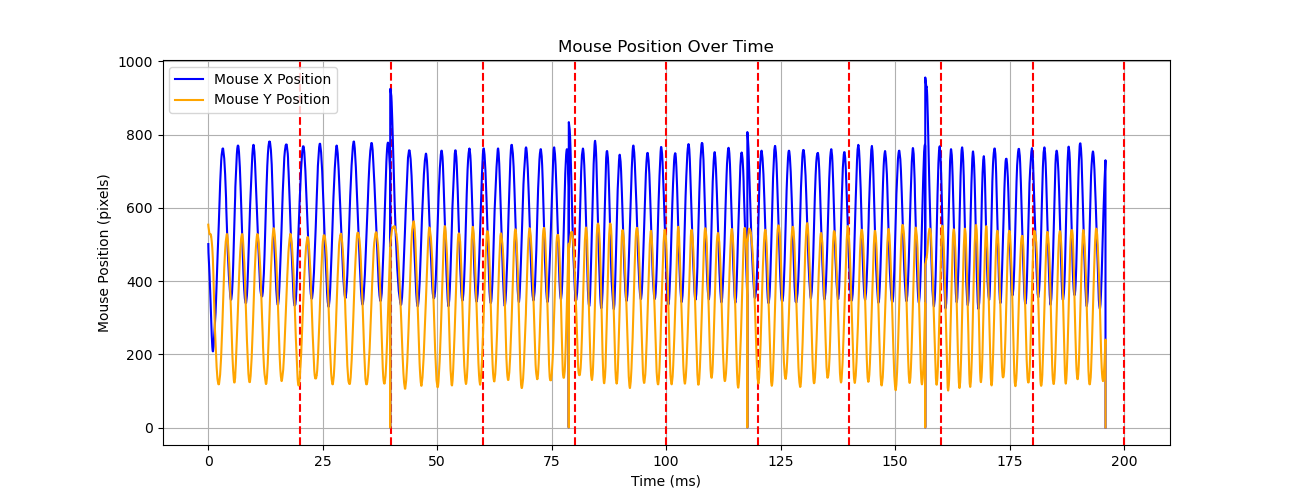

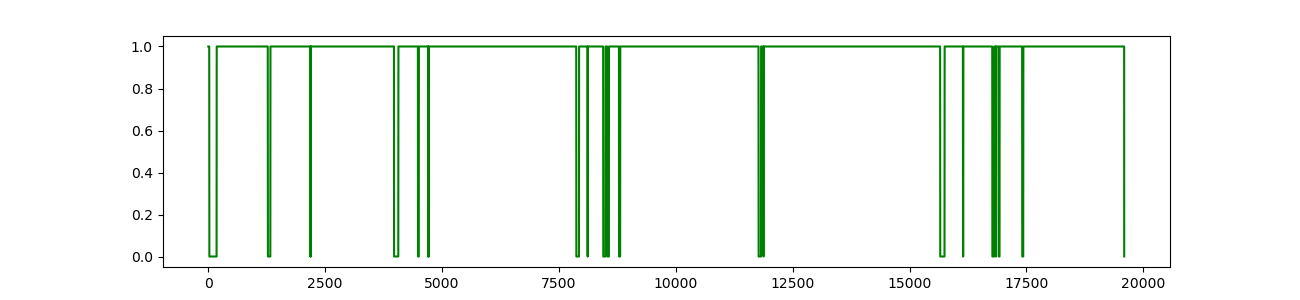

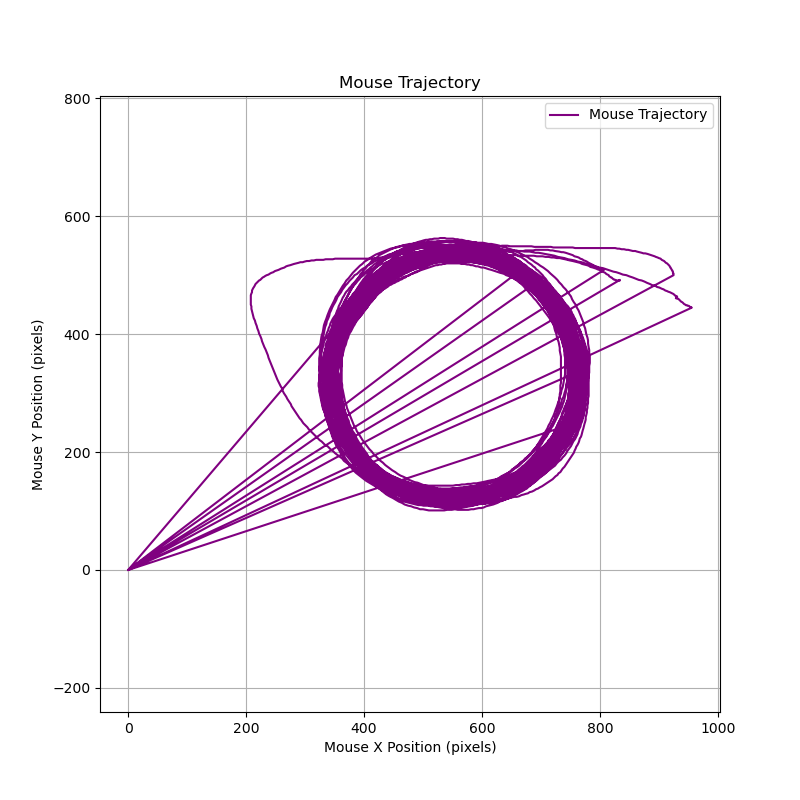

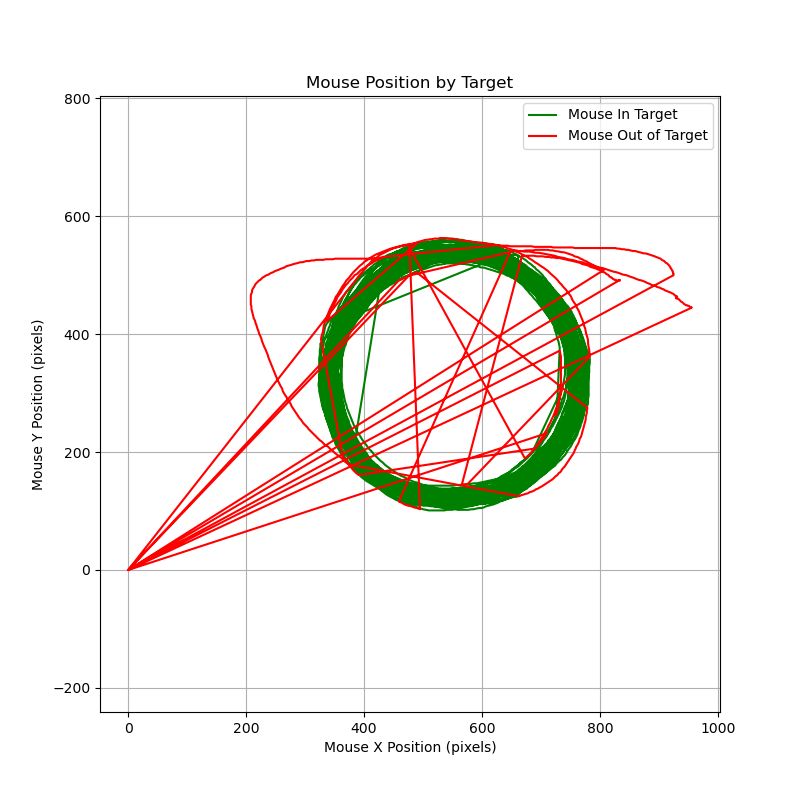

In [ ]:
#load csv data
data = np.loadtxt("001MoDe_R1.csv", delimiter=",", skiprows=4)
# timestamp,mouseX,mouseY,mouseInTarget

mouseX = data[:,1]     
mouseY = data[:,2]     
time = np.arange(len(mouseX)) / 100 #Convert to seconds
mouse_target = data[:,3]
#Plot 
plt.figure(figsize=(13, 5))
#Plot axvline at 20 40 60 80 100 120 140 160 180 200
plt.axvline(x=20, color='red', linestyle='--')
plt.axvline(x=40, color='red', linestyle='--')
plt.axvline(x=60, color='red', linestyle='--')
plt.axvline(x=80, color='red', linestyle='--')
plt.axvline(x=100, color='red', linestyle='--')
plt.axvline(x=120, color='red', linestyle='--')
plt.axvline(x=140, color='red', linestyle='--')
plt.axvline(x=160, color='red', linestyle='--')
plt.axvline(x=180, color='red', linestyle='--')
plt.axvline(x=200, color='red', linestyle='--')
plt.plot(time, mouseX, label="Mouse X Position", color="blue")
plt.plot(time, mouseY, label="Mouse Y Position", color="orange")
plt.xlabel("Time (ms)")
plt.ylabel("Mouse Position (pixels)")
plt.title("Mouse Position Over Time")
plt.legend()
plt.grid()
plt.show()

#Plot mouse target
plt.figure(figsize=(13, 3))
plt.plot(mouse_target, label="Mouse In Target", color="green")
plt.show()

#Coordonée de mouse = (mouseX, mouseY)
Mouse = np.column_stack((mouseX, mouseY))
#Afficher la trajectoire de la souris
plt.figure(figsize=(8, 8))
plt.plot(mouseX, mouseY, label="Mouse Trajectory", color="purple")
plt.xlabel("Mouse X Position (pixels)")
plt.ylabel("Mouse Y Position (pixels)")
plt.title("Mouse Trajectory")
plt.legend()
plt.grid()
plt.axis('equal')
plt.show()

#Afficher quand la souris est dans la cible
plt.figure(figsize=(8, 8))
plt.plot(mouseX[mouse_target==1], mouseY[mouse_target==1], 'g', label="Mouse In Target")
plt.plot(mouseX[mouse_target==0], mouseY[mouse_target==0], 'r', label="Mouse Out of Target")
plt.xlabel("Mouse X Position (pixels)")
plt.ylabel("Mouse Y Position (pixels)")
plt.title("Mouse Position by Target")
plt.legend()
plt.grid()
plt.axis('equal')
plt.show()


